# Analysis of Supreme Court Case Transcripts Since 2005

We were specifically interested in investigating differences in linguistic style between male and female Supreme Court Justices and among the Justices themselves. Our initial hypothesis was that female justices tend to soften or reduce the impact of their words by using phrases like "Would you like to consider the posibility..." or "I would have thought perhaps..." also known as hedging. We were also interested in how the sentiment of dialogue changed over time, as well as over the course of a justice's lifetime. Our investigation led us through the following questions:

Gender Text Analysis:
- Do female justices use hedging more than male justices? 
- Do female or male justices get interrupted more often?
- Do female justices tend to use more positive or negative dialogue? Which justices tend to use more positive or negative dialogue? 
- Are male or female justices more polarized in their dialogue? Are certain justices more polarized in their dialogue?
- Are male or female justices more opinionated or subjective? Are certain justices more opinionated or subjective? 

Text Evolution Analysis:
- Do older justices tend to be more negative or opinionated? 
- Has the dialogue of justices become more polarized over time? 

Please enjoy our journey navigating through a 100,000 row data frame of Supreme Court Case Dialogue.

In [1]:
import pandas as pd

In [101]:
justices = pd.read_csv("justices-dialogue.csv")
justices.head()

,speaker,text_blocks,duration,gender,case_id
0,"John G. Roberts, Jr.",We'll hear argument first this morning in Case...,7.44,male,24798
1,Sonia Sotomayor,"I'm not quite sure, putting this outside the c...",23.48,female,24798
2,Sonia Sotomayor,But that's not true.,0.84,female,24798
3,Sonia Sotomayor,All defendants don't have a shot at removal. O...,11.84,female,24798
4,Sonia Sotomayor,So not every defendant individually has a righ...,5.88,female,24798


# Analyzing the Use of Modals

A common part of speech used in hedging is a modal, which is a type of auxiliary verb that expresses possibility. Some examples of modals include the words "would", "should", "may", and "might". To explore whether or not female or male justices hedge more, we used the NLTK library to count up the number of modals in each line of dialogue, and comparing them between genders. 

The pos_tag function from the NLTK library takes in a tokenized sentence and tags each word with its part of speech. Let's look at a quick example to see how it works:

In [34]:
from nltk import word_tokenize, pos_tag

text = word_tokenize("would you like to go with me")
pos_tag(text)

[('would', 'MD'),
 ('you', 'PRP'),
 ('like', 'VB'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('with', 'IN'),
 ('me', 'PRP')]

We are interested in words tagged "MD", or modal. The function count_modal passes in a tagged sentence and counts how many modals there are in the sentence.

In [35]:
def count_modal(tagged):
    return len([word for word in tagged if word[1] == "MD"])

Now, we will add a column called "modal" to our data frame justices containing the proportion of modals in each line, and compare them for each gender.

In [36]:
justices["tokenized"] = justices["text_blocks"].apply(word_tokenize)
justices["tagged"] = justices["tokenized"].apply(pos_tag)
justices["modal"] = justices["tagged"].apply(count_modal)

In [37]:
justices["count"] = justices["tokenized"].apply(len)
justices["modal_prop"] = justices["modal"] / justices["count"]

In [38]:
justices.groupby("gender").modal_prop.mean()

gender
female    0.017171
male      0.017346
Name: modal_prop, dtype: float64

The proportions weren't quite what we expected. This made us realize an issue with using modal proportions as a measure of hedging: the meaning of the sentence varies drastically depending on the _location_ of the modal in the sentence. For example: 

"**Would** it be possible for you to elaborate?"

vs.

"You **would** not believe what I saw today!"

The first example would be classified as hedging whereas the second would not, yet they both have the same modal proportion. It appears that sentences that start with a modal may be a better measure of hedging. We investigated the proportion of lines starting with a modal between each gender next.

In [39]:
def first_modal(tagged):
    return tagged[0][1] == "MD"

In [40]:
justices["first_modal"] = justices["tagged"].apply(first_modal)

In [41]:
gender_modal_counts = pd.crosstab(justices.gender, justices.first_modal)
gender_counts = gender_modal_counts.sum(axis=1)
modal_given_gender = gender_modal_counts.divide(gender_counts, axis=0)
modal_given_gender

first_modal,False,True
gender,,
female,0.978029,0.021971
male,0.984474,0.015526


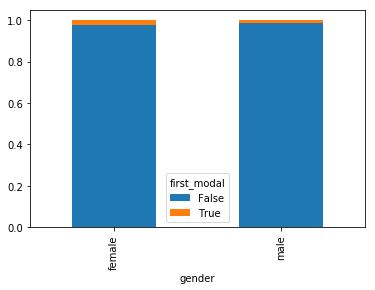

In [42]:
modal_given_gender.plot.bar(stacked=True)

It appears that female justices tend to start more lines with a modal than men do. This could be evidence that women hedge more often than men, and may be a helpful predictor in our machine learning model in the next notebook.

# Interruption Analysis

We wanted to investigate of male or female justices got interrupted more by lawyers, attorneys, and others participating in the case. To do this, we wrote a function that returns a boolean if the last word in a text block is "--" which represents an interruption. We used this function to create a boolean column in our data set that indicates whether not a statement was interrupted, and analyzed the proportion between men and women.

Let's test our function on the following text block from Sonia Sotomayor who was interrupted:

In [44]:
justices.iloc[6].text_blocks

'Well, how about in a -- how about --'

In [45]:
def interrupted(text):
    return text.split()[-1]=="--"

interrupted(justices.iloc[6].text_blocks)

True

Now, we will apply this function to the every text block in our data set.

In [46]:
justices["interrupted"] = justices["text_blocks"].apply(interrupted)

In [47]:
justices.groupby("gender").interrupted.value_counts()

gender  interrupted
female  False          26931
        True            1789
male    False          71857
        True            1826
Name: interrupted, dtype: int64

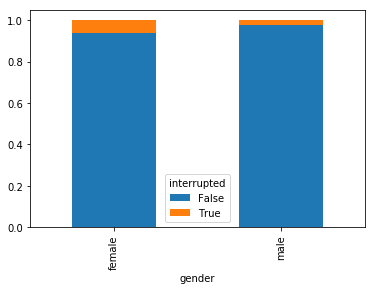

In [48]:
gender_interrupted_counts = pd.crosstab(justices.gender, justices.interrupted)
gender_counts = gender_interrupted_counts.sum(axis=1)
interrupted_given_gender = gender_interrupted_counts.divide(gender_counts, axis=0)
interrupted_given_gender.plot.bar(stacked=True)

In [49]:
interrupted_given_gender

interrupted,False,True
gender,,
female,0.937709,0.062291
male,0.975218,0.024782


6.23% of the lines that female justices speak get interrupted while only 2.48% of the lines that male justices speak get interrupted--that's almost three times as often! It appears that lawyers and attorneys may treat female justices differently in this way. 

The function interrupted passes an nlp object and returns whether or not the last word had the shape "--". We will then apply this function to every text block in the data frame. 

# Sentiment Analysis

We will now investigate our questions involving sentiment and subjectivity using the TextBlob package, which contains functions that will score the sentiment of a text with a number between -1 and 1 with -1 representing very negative text and 1 representing very positive text. It also scores the subjectivity of a text, or how opinionated it is, with a number between 0 and 1 with 0 representing an objective text and 1 representing a very subjective text.

Let's get a feel for these functions by taking a look at how it scores the following line by justice John G. Roberts which has a somewhat apologetic tone to it. 

In [59]:
justices.iloc[2971].text_blocks

"I'm sorry, let me just keep track here. The evidence was cut off when, in 2008?"

In [61]:
from textblob import TextBlob
opinion = TextBlob(justices.iloc[2971].text_blocks)
opinion.sentiment

Sentiment(polarity=-0.5, subjectivity=1.0)

The sentiment score is -0.5 indicating a more negative tone, and the subjectivity is 1.0 indicating an opinionated statement.

The following functions pass in a blob object and return the sentiment polarity, sentiment, and subjectivity of the blob respectively. We measured polarity simply by taking the absolute value of sentiment. We will then apply these functions to every line in the data frame to obtain scores for each line.

In [62]:
import numpy as np
def sentiment_polarity(blob):
    return np.abs(blob.sentiment.polarity)

def sentiment(blob):
    return blob.sentiment.polarity

def subjectivity(blob):
    return blob.sentiment.subjectivity

#test on the line from above
sentiment_polarity(opinion), sentiment(opinion), subjectivity(opinion)

(0.5, -0.5, 1.0)

In [64]:
justices["textblob"] = justices["text_blocks"].apply(TextBlob)
justices["sentiment_polarity"] = justices["textblob"].apply(sentiment_polarity)
justices["sentiment"] = justices["textblob"].apply(sentiment)
justices["subjectivity"] = justices["textblob"].apply(subjectivity)

Let's examine how sentiment varies by gender and by justice. 

In [67]:
justices.groupby("gender").sentiment.mean().sort_values(ascending=False)

gender
male      0.047341
female    0.040845
Name: sentiment, dtype: float64

gender
female    AxesSubplot(0.125,0.125;0.775x0.755)
male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: sentiment, dtype: object

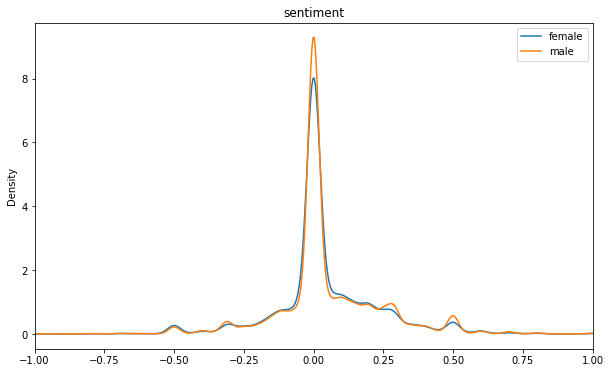

In [68]:
%matplotlib inline
justices.groupby("gender").sentiment.plot.density(xlim = (-1, 1), legend=True, figsize=(10,6), title="sentiment")


In [69]:
justices.groupby("speaker").sentiment.mean().sort_values(ascending=False)

speaker
Clarence Thomas         0.108442
Neil Gorsuch            0.071577
Stephen G. Breyer       0.060952
John Paul Stevens       0.053692
Elena Kagan             0.053442
Samuel A. Alito, Jr.    0.044392
John G. Roberts, Jr.    0.043214
Ruth Bader Ginsburg     0.042213
Antonin Scalia          0.040899
Anthony M. Kennedy      0.037662
Sonia Sotomayor         0.032399
Name: sentiment, dtype: float64

speaker
Anthony M. Kennedy      AxesSubplot(0.125,0.125;0.775x0.755)
Antonin Scalia          AxesSubplot(0.125,0.125;0.775x0.755)
Clarence Thomas         AxesSubplot(0.125,0.125;0.775x0.755)
Elena Kagan             AxesSubplot(0.125,0.125;0.775x0.755)
John G. Roberts, Jr.    AxesSubplot(0.125,0.125;0.775x0.755)
John Paul Stevens       AxesSubplot(0.125,0.125;0.775x0.755)
Neil Gorsuch            AxesSubplot(0.125,0.125;0.775x0.755)
Ruth Bader Ginsburg     AxesSubplot(0.125,0.125;0.775x0.755)
Samuel A. Alito, Jr.    AxesSubplot(0.125,0.125;0.775x0.755)
Sonia Sotomayor         AxesSubplot(0.125,0.125;0.775x0.755)
Stephen G. Breyer       AxesSubplot(0.125,0.125;0.775x0.755)
Name: sentiment, dtype: object

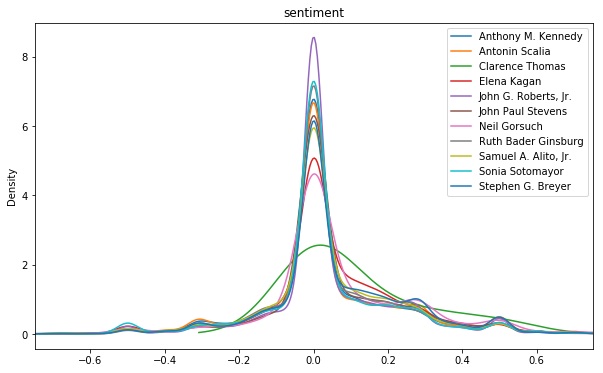

In [70]:
justices.groupby("speaker").sentiment.plot.density(xlim = (-0.75, 0.75), legend = True, figsize=(10,6), title="sentiment")

It appears that the justices tend to do a good job of remaining neutral in the sentiment of their dialogue. However, it does appear that male judges have a slightly higher or more positive sentiment than female judges. 

In terms of justices, it appears that Clarence Thomas has the most positive sentiment while Sandra Day O'Connor has the most negative sentiment.

Could this be because male judges have stronger wording, or are they truly more positive in their sentiment? Let's examine the polarity of their dialogue next. 

In [71]:
justices.groupby("gender").sentiment_polarity.mean().sort_values(ascending=False)

gender
male      0.114990
female    0.110706
Name: sentiment_polarity, dtype: float64

gender
female    AxesSubplot(0.125,0.125;0.775x0.755)
male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: sentiment_polarity, dtype: object

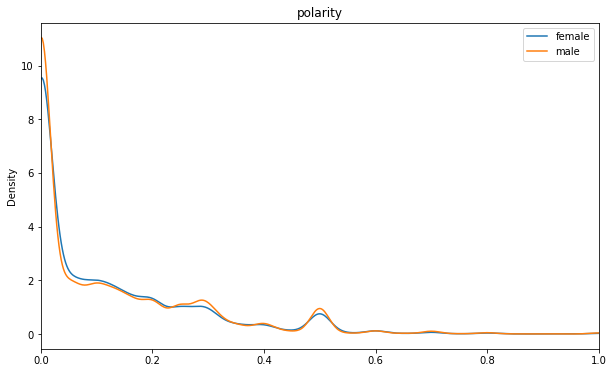

In [72]:
justices.groupby("gender").sentiment_polarity.plot.density(xlim = (0, 1), legend=True, figsize=(10,6), title="polarity")


In [73]:
justices.groupby("speaker").sentiment_polarity.mean().sort_values(ascending=False)

speaker
Neil Gorsuch            0.127451
Stephen G. Breyer       0.126300
Elena Kagan             0.124736
Antonin Scalia          0.122219
Clarence Thomas         0.115512
Samuel A. Alito, Jr.    0.115140
Anthony M. Kennedy      0.110054
John Paul Stevens       0.109250
Sonia Sotomayor         0.107356
Ruth Bader Ginsburg     0.105863
John G. Roberts, Jr.    0.101263
Name: sentiment_polarity, dtype: float64

speaker
Anthony M. Kennedy      AxesSubplot(0.125,0.125;0.775x0.755)
Antonin Scalia          AxesSubplot(0.125,0.125;0.775x0.755)
Clarence Thomas         AxesSubplot(0.125,0.125;0.775x0.755)
Elena Kagan             AxesSubplot(0.125,0.125;0.775x0.755)
John G. Roberts, Jr.    AxesSubplot(0.125,0.125;0.775x0.755)
John Paul Stevens       AxesSubplot(0.125,0.125;0.775x0.755)
Neil Gorsuch            AxesSubplot(0.125,0.125;0.775x0.755)
Ruth Bader Ginsburg     AxesSubplot(0.125,0.125;0.775x0.755)
Samuel A. Alito, Jr.    AxesSubplot(0.125,0.125;0.775x0.755)
Sonia Sotomayor         AxesSubplot(0.125,0.125;0.775x0.755)
Stephen G. Breyer       AxesSubplot(0.125,0.125;0.775x0.755)
Name: sentiment_polarity, dtype: object

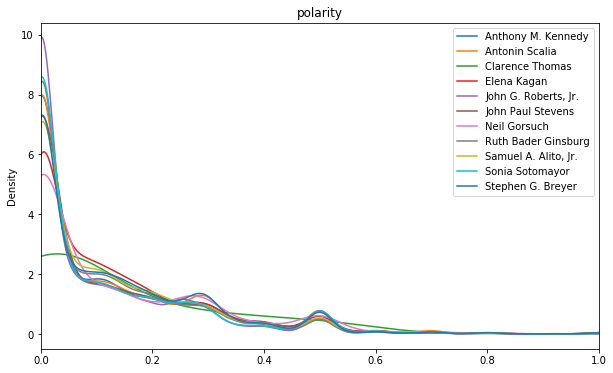

In [74]:
justices.groupby("speaker").sentiment_polarity.plot.density(xlim = (0, 1), legend = True, figsize=(10,6), title="polarity")

It appears that female justices have a slightly lower polarity score in their dialogue. The distribution also appears to be very similar, with peaks at 0.3 and 0.5. It is possible that male judges tend to have slightly more polarized dialogue in general, which may explain their higher sentiment score.

Let's now examine how opinionated male and female justices tend to be, and how opinionted each judge tends to be.

In [75]:
justices.groupby("gender").subjectivity.mean()

gender
female    0.310526
male      0.305829
Name: subjectivity, dtype: float64

gender
female    AxesSubplot(0.125,0.125;0.775x0.755)
male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: subjectivity, dtype: object

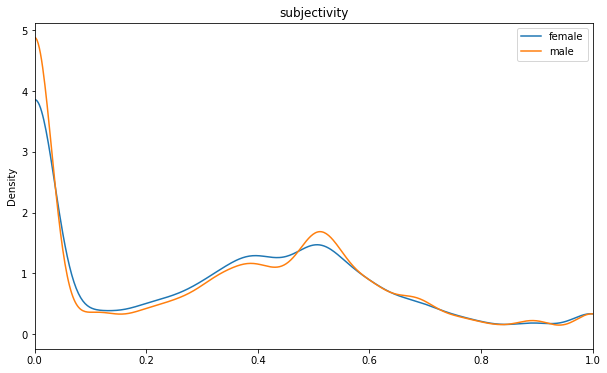

In [76]:
justices.groupby("gender").subjectivity.plot.density(xlim = (0, 1), legend=True, figsize=(10,6), title="subjectivity")

In [77]:
justices.groupby("speaker").subjectivity.mean().sort_values(ascending=False)

speaker
Elena Kagan             0.358978
Stephen G. Breyer       0.334148
Antonin Scalia          0.322588
Samuel A. Alito, Jr.    0.317068
Neil Gorsuch            0.302954
Ruth Bader Ginsburg     0.299380
Sonia Sotomayor         0.293652
John Paul Stevens       0.287418
Anthony M. Kennedy      0.286795
John G. Roberts, Jr.    0.276003
Clarence Thomas         0.187430
Name: subjectivity, dtype: float64

speaker
Anthony M. Kennedy      AxesSubplot(0.125,0.125;0.775x0.755)
Antonin Scalia          AxesSubplot(0.125,0.125;0.775x0.755)
Clarence Thomas         AxesSubplot(0.125,0.125;0.775x0.755)
Elena Kagan             AxesSubplot(0.125,0.125;0.775x0.755)
John G. Roberts, Jr.    AxesSubplot(0.125,0.125;0.775x0.755)
John Paul Stevens       AxesSubplot(0.125,0.125;0.775x0.755)
Neil Gorsuch            AxesSubplot(0.125,0.125;0.775x0.755)
Ruth Bader Ginsburg     AxesSubplot(0.125,0.125;0.775x0.755)
Samuel A. Alito, Jr.    AxesSubplot(0.125,0.125;0.775x0.755)
Sonia Sotomayor         AxesSubplot(0.125,0.125;0.775x0.755)
Stephen G. Breyer       AxesSubplot(0.125,0.125;0.775x0.755)
Name: subjectivity, dtype: object

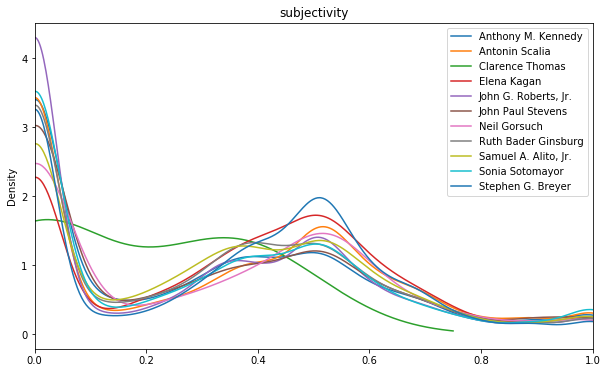

In [78]:
justices.groupby("speaker").subjectivity.plot.density(xlim = (0, 1), legend=True, figsize=(10,6), title="subjectivity")

It apppears that female justices have slightly more opinionated dialogue than male justices. Justice Elena Kagen appears to have the most opinionated dialogue while justice Clarence thomas seems to have the most neutral dialogue.

In [79]:
justices.to_csv("justices_sentiment.csv")

# Age Analysis

We will now work with a new data frame called ages, details on how we gathered and cleaned this data can be found in the data cleaining notebook. We will conduct sentiment analysis based on age to see how sentiments change as justices age.

In [102]:
ages = pd.read_csv("age.csv")
ages.justice_name.unique()
ages.head()

,docket_num,case_name,case_id,year,party_won,judge_decision,justice_name,text,bday,age_during_case
0,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,JGRoberts,We'll hear argument this morning in Case 09-55...,1955,54.0
1,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,JPStevens,Isn't there another-- --Isn't there another po...,1920,89.0
2,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,AScalia,What -- what about requiring disclosure of cam...,1936,73.0
3,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,AMKennedy,"Well, let me -- let me ask you, could the oppo...",1936,73.0
4,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,RBGinsburg,But -- but don't you have -- I thought we were...,1933,76.0


We want to merge the dataset with the ages with the justices dataset so that we can analyze how each line of text varies among differen ages of the judges. To do this, we will need the case id and name columns to match. 

In [84]:
ages.justice_name = ages.justice_name.replace("JGRoberts", "John G. Roberts, Jr.")
ages.justice_name = ages.justice_name.replace("JPStevens", "John Paul Stevens")
ages.justice_name = ages.justice_name.replace("AScalia", "Antonin Scalia")
ages.justice_name = ages.justice_name.replace("AMKennedy", "Anthony M. Kennedy")
ages.justice_name = ages.justice_name.replace("RBGinsburg", "Ruth Bader Ginsburg")
ages.justice_name = ages.justice_name.replace("SGBreyer", "Stephen G. Breyer")
ages.justice_name = ages.justice_name.replace("SAAlito", "Samuel A. Alito, Jr.")
ages.justice_name = ages.justice_name.replace("SSotomayor", "Sonia Sotomayor")
ages.justice_name = ages.justice_name.replace("EKagan", "Elena Kagan")
ages.justice_name = ages.justice_name.replace("CThomas", "Clarence Thomas")
ages.justice_name = ages.justice_name.replace("NMGorsuch", "Neil Gorsuch")
ages = ages.rename(index=str, columns={"justice_name": "speaker"})

In [85]:
justices_age = justices.merge(ages, on=["case_id", "speaker"], how="inner")
justices_age.head()

,speaker,text_blocks,duration,gender,case_id,tokenized,tagged,modal,count,modal_prop,...,subjectivity,sentiment,docket_num,case_name,year,party_won,judge_decision,text,bday,age_during_case
0,"John G. Roberts, Jr.",We'll hear argument this morning in consolidat...,17.010,male,23268,"[We, 'll, hear, argument, this, morning, in, c...","[(We, PRP), ('ll, MD), (hear, VB), (argument, ...",1,39,0.025641,...,0.100000,0.000000,13-354,Burwell v. Hobby Lobby Stores,2013.0,defendant,majority,We'll hear argument this morning in consolidat...,1955,58.0
1,"John G. Roberts, Jr.",I thought -- I thought that part of the religi...,7.854,male,23268,"[I, thought, --, I, thought, that, part, of, t...","[(I, PRP), (thought, VBD), (--, :), (I, PRP), ...",0,23,0.000000,...,0.250000,0.000000,13-354,Burwell v. Hobby Lobby Stores,2013.0,defendant,majority,We'll hear argument this morning in consolidat...,1955,58.0
2,"John G. Roberts, Jr.",She's right about that. [Laughter],3.437,male,23268,"[She, 's, right, about, that, ., [, Laughter, ]]","[(She, PRP), ('s, VBZ), (right, JJ), (about, I...",0,9,0.000000,...,0.535714,0.285714,13-354,Burwell v. Hobby Lobby Stores,2013.0,defendant,majority,We'll hear argument this morning in consolidat...,1955,58.0
3,"John G. Roberts, Jr.","Thank you, Mr. Clement. General Verrilli.",6.070,male,23268,"[Thank, you, ,, Mr., Clement, ., General, Verr...","[(Thank, NNP), (you, PRP), (,, ,), (Mr., NNP),...",0,9,0.000000,...,0.500000,0.050000,13-354,Burwell v. Hobby Lobby Stores,2013.0,defendant,majority,We'll hear argument this morning in consolidat...,1955,58.0
4,"John G. Roberts, Jr.",That's a statement that is inconsistent with R...,16.526,male,23268,"[That, 's, a, statement, that, is, inconsisten...","[(That, DT), ('s, VBZ), (a, DT), (statement, N...",0,38,0.000000,...,0.327778,0.122222,13-354,Burwell v. Hobby Lobby Stores,2013.0,defendant,majority,We'll hear argument this morning in consolidat...,1955,58.0


Let's look at how the sentiment of justices changes depending on their age. 

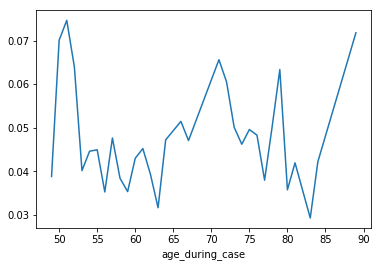

In [86]:
justices_age.groupby("age_during_case").sentiment.mean().plot.line()

In [87]:
justices_age["age_during_case"].corr(justices_age["sentiment"])

0.00656794373369757

There does not appear to be much of a relationship between sentiment and age, and the correlation is nearly 0 indicating no linear relationship. However, the values do seem to go up and down a lot, and increase at the end of their career.

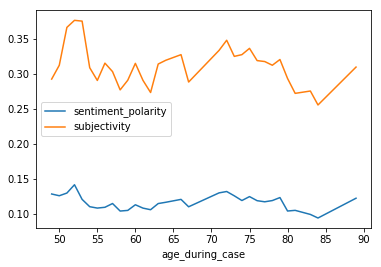

In [88]:
justices_age.groupby("age_during_case").sentiment_polarity.mean().plot.line(legend=True)
justices_age.groupby("age_during_case").subjectivity.mean().plot.line(legend=True)

In [89]:
(justices_age["age_during_case"].corr(justices_age["sentiment_polarity"]), 
    justices_age["age_during_case"].corr(justices_age["subjectivity"]))

(0.00877241777890505, 0.004591464498410978)

Again, there appears to be no relationship between age and polarity or subjectivity.

Another thing we wanted to look at is whether or not older judges got interrupted more often than younger judges. To do this, we will plot the proportion of lines that were interrupted over age. 

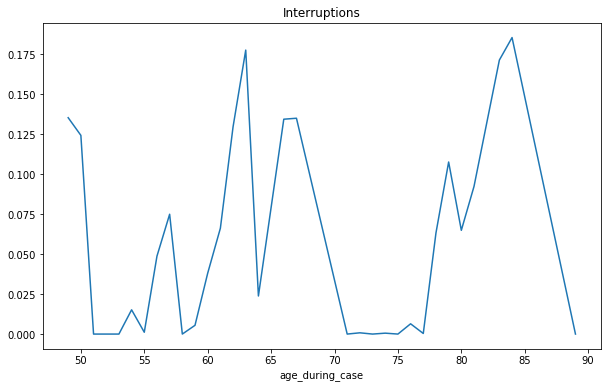

In [90]:
justices_age.groupby("age_during_case").interrupted.mean().plot.line(figsize=(10,6), title="Interruptions")

In [91]:
justices_age["age_during_case"].corr(justices_age["interrupted"])

-0.0070814171969516004

There also does not seem to be much of a relationship between interruption rate and age, however it does seem to go down towards the end of a justice's career.

# Evolution of Sentiment

Have justices gotten more positive or negative over time? Have their statements become more polarized or opinionated over time? Let's see how these values changed since 2009. 

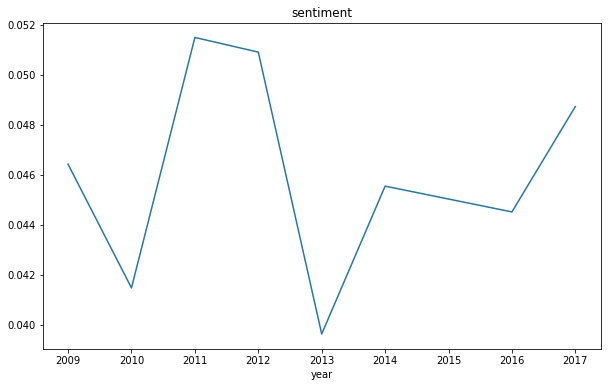

In [92]:
justices_age.groupby("year").sentiment.mean().plot.line(figsize=(10,6), title="sentiment")

In [93]:
justices_age["year"].corr(justices_age["sentiment"])

0.002567270733151204

There does not appear to be much change in sentiment since 2009. 

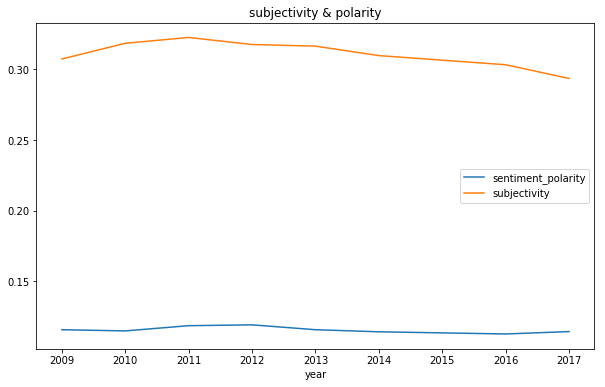

In [94]:
justices_age.groupby("year").sentiment_polarity.mean().plot.line(legend=True, figsize=(10,6), title="subjectivity & polarity")
justices_age.groupby("year").subjectivity.mean().plot.line(legend=True, figsize=(10,6))

In [95]:
(justices_age["year"].corr(justices_age["sentiment_polarity"]), 
    justices_age["year"].corr(justices_age["subjectivity"]))

(-0.006485295829310005, -0.026197332325855534)

It appears that polarity and subjectivity have gone down slightly since 2009, but still not a significant amount. 